In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

data_path = "./dataset/datasetTC4.dat"

data = np.loadtxt(data_path)
print(data.shape)
data

(310, 6)


array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53],
       ...,
       [ 61.45,  22.69,  46.17,  38.75, 125.67,  -2.71],
       [ 45.25,   8.69,  41.58,  36.56, 118.55,   0.21],
       [ 33.84,   5.07,  36.64,  28.77, 123.95,  -0.2 ]])

In [15]:
# Normalização do dataset usando z-score
def z_score_norm(dataset):
    std = np.std(dataset, axis=0)
    normalized = (dataset - np.mean(dataset, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    return normalized

data = z_score_norm(data)
data

array([[ 0.14722652,  0.50111133, -0.66512805, -0.18460234, -1.44783071,
        -0.70794606],
       [-1.24570706, -0.74889057, -1.45276272, -1.04124965, -0.26402779,
        -0.57967342],
       [ 0.48427345,  0.46808485, -0.0993699 ,  0.27282344, -0.89729467,
        -0.79541679],
       ...,
       [ 0.05541029,  0.51512256, -0.31098936, -0.31369641,  0.58283504,
        -0.77354911],
       [-0.88599664, -0.88600047, -0.55877847, -0.47711606,  0.04734096,
        -0.69567882],
       [-1.54904929, -1.24829085, -0.82546218, -1.05841244,  0.45347411,
        -0.70661266]])

In [16]:
# Inicialização dos parâmetros
Kmax = 10 # Número de protótipos
rounds = 30 # Número de rodadas
epochs = 20 # Número de iterações
ref_index = "Dunn" # Índice de referência para escolha do K

In [17]:
# Implementação do Índice de Dunn, oss outros índices foram usados do Scikit-learn
def dunn_index(data, labels):
    min_intercluster_dists = np.max(pairwise_distances(data, metric='euclidean'))
    max_intracluster_dists = 0.0
    
    for cluster_label in np.unique(labels):
        cluster_points = data[labels == cluster_label]
        
        if cluster_label < len(np.unique(labels)) - 1:
            not_cluster_points = data[labels > cluster_label]
            intercluster_dists = pairwise_distances(cluster_points, not_cluster_points, metric='euclidean')
            min_intercluster_dists = min(np.min(intercluster_dists), min_intercluster_dists)
            
        intracluster_dists = pairwise_distances(cluster_points, metric='euclidean')
        max_intracluster_dists = max(np.max(intracluster_dists), max_intracluster_dists)

    return min_intercluster_dists / max_intracluster_dists

In [18]:
# Batch K-means
def kmeans(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)

    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.linalg.norm(data[t, :] - updt_proto, axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)

        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.mean(partition, axis=0)

    return updt_proto, SSD

In [19]:
# Rodada prévia para encontrar o melhor valor de K por cada índice
k_by_dunn, k_by_ch, k_by_db = [], [], []

for ext_rnd in range(100):
    best_dunns, best_chs, best_dbs = [], [], []
    
    for K in range(2, Kmax+1):
        rnd_final_prototypes, rnd_ssds = [], []
        
        for rnd in range(10): # Aplicando K-médias nos dados por rodada
            idxs = np.random.choice(data.shape[0], K, replace=False) # Aleatoriedade dos protótipos
            prototypes = data[idxs, :] # Protótipos definidos
            
            prototypes, kmeans_SSD = kmeans(data, prototypes, epochs) # Aplicando o K-means
            
            rnd_final_prototypes.append(prototypes)
            rnd_ssds.append(kmeans_SSD)
        
        k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final
        k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
    
        labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
    
        best_dunns.append(dunn_index(data, labels)) # Salvando o Índice de Dunn de K
        best_chs.append(calinski_harabasz_score(data, labels)) # Salvando o Índice de Calinski-Harabasz de K
        best_dbs.append(davies_bouldin_score(data, labels)) # Salvando o Índice de Davies-Bouldin de K
    
    k_by_dunn.append(np.argmax(best_dunns) + 2) # Melhor K segundo o Índice de Dunn
    k_by_ch.append(np.argmax(best_chs) + 2) # Melhor K segundo o Índice de Calinski-Harabasz
    k_by_db.append(np.argmin(best_dbs) + 2) # Melhor K segundo o Índice de Davies-Bouldin
    
    print("Round {}/100 finished".format(ext_rnd + 1))
    
unique_dunn, counts_dunn = np.unique(k_by_dunn, return_counts=True)
unique_ch, counts_ch = np.unique(k_by_ch, return_counts=True)
unique_db, counts_db = np.unique(k_by_db, return_counts=True)

print("Best K per Round by Dunn Index:", dict(zip(unique_dunn, counts_dunn)))
print("Best K per Round by Calinski-Harabasz Index:", dict(zip(unique_ch, counts_ch)))
print("Best K per Round by Davies-Bouldin Index:", dict(zip(unique_db, counts_db)))

Round 1/100 finished
Round 2/100 finished
Round 3/100 finished
Round 4/100 finished
Round 5/100 finished
Round 6/100 finished
Round 7/100 finished
Round 8/100 finished
Round 9/100 finished
Round 10/100 finished
Round 11/100 finished
Round 12/100 finished
Round 13/100 finished
Round 14/100 finished
Round 15/100 finished
Round 16/100 finished
Round 17/100 finished
Round 18/100 finished
Round 19/100 finished
Round 20/100 finished
Round 21/100 finished
Round 22/100 finished
Round 23/100 finished
Round 24/100 finished
Round 25/100 finished
Round 26/100 finished
Round 27/100 finished
Round 28/100 finished
Round 29/100 finished
Round 30/100 finished
Round 31/100 finished
Round 32/100 finished
Round 33/100 finished
Round 34/100 finished
Round 35/100 finished
Round 36/100 finished
Round 37/100 finished
Round 38/100 finished
Round 39/100 finished
Round 40/100 finished
Round 41/100 finished
Round 42/100 finished
Round 43/100 finished
Round 44/100 finished
Round 45/100 finished
Round 46/100 finish

In [20]:
# Rodar novamente usando o melhor K (moda) pelo índice escolhido
if ref_index == "Dunn":
    k_mode = unique_dunn[np.argmax(counts_dunn)]
elif ref_index == "CH":
    k_mode = unique_ch[np.argmax(counts_ch)]
elif ref_index == "DB":
    k_mode = unique_db[np.argmax(counts_db)]

# Aplicando K-médias nos dados por rodada
rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
for rnd in range(rounds):
    idxs = np.random.choice(data.shape[0], k_mode, replace=False) # Aleatoriedade dos protótipos
    prototypes = data[idxs, :] # Protótipos definidos
    rnd_prototypes.append(prototypes)
    
    prototypes, kmeans_SSD = kmeans(data, prototypes, epochs) # Aplicando o K-means
    
    rnd_final_prototypes.append(prototypes)
    rnd_ssds.append(kmeans_SSD)

k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final

k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
k_best_ssd = rnd_ssds[k_best_ssd_idx]

labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
dn_index = dunn_index(data, labels) # Índice de Dunn
ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

print("Best K (using {} Index) = {}".format(ref_index, k_mode))
print("Dunn Index = {}".format(dn_index))
print("Calinski-Harabasz Index = {}".format(ch_index))
print("Davies-Bouldin Index = {}".format(db_index))
print("Best SSD =", k_best_ssd[-1])

Best K (using Dunn Index) = 6
Dunn Index = 0.05125455054681495
Calinski-Harabasz Index = 118.06818807153708
Davies-Bouldin Index = 1.164954982767771
Best SSD = 632.2421064318673


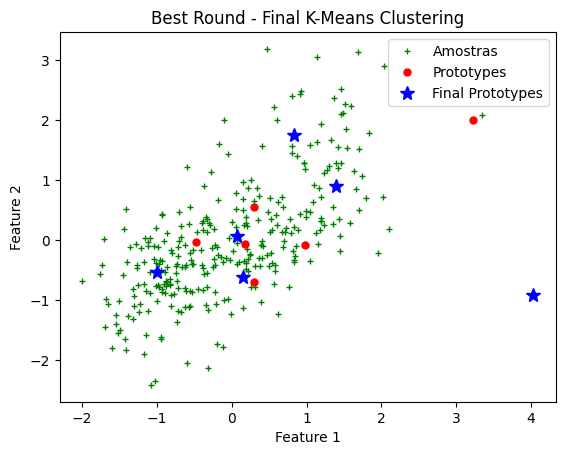

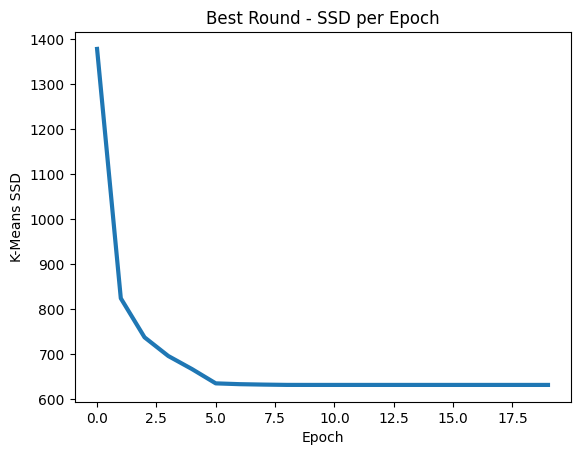

In [21]:
# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes[:, 0], k_best_prototypes[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes[:, 0], k_best_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Means Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(k_best_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Means SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()

In [22]:
# Batch K-medians
def kmedians(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)
    
    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.sum(np.abs(data[t, :] - updt_proto), axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)
    
        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.median(partition, axis=0)

    return updt_proto, SSD

In [23]:
# Rodar novamente usando o melhor K (moda) pelo índice escolhido
if ref_index == "Dunn":
    k_mode = unique_dunn[np.argmax(counts_dunn)]
elif ref_index == "CH":
    k_mode = unique_ch[np.argmax(counts_ch)]
elif ref_index == "DB":
    k_mode = unique_db[np.argmax(counts_db)]

# Aplicando K-medianas nos dados por rodada
rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
for rnd in range(rounds):
    idxs = np.random.choice(data.shape[0], k_mode, replace=False) # Aleatoriedade dos protótipos
    prototypes = data[idxs, :] # Protótipos definidos
    rnd_prototypes.append(prototypes)
    
    prototypes, kmedians_SSD = kmedians(data, prototypes, epochs) # Aplicando o K-medians
    
    rnd_final_prototypes.append(prototypes)
    rnd_ssds.append(kmedians_SSD)

k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final

k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
k_best_ssd = rnd_ssds[k_best_ssd_idx]

labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
dn_index = dunn_index(data, labels) # Índice de Dunn
ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

print("Best K (using {} Index) = {}".format(ref_index, k_mode))
print("Dunn Index = {}".format(dn_index))
print("Calinski-Harabasz Index = {}".format(ch_index))
print("Davies-Bouldin Index = {}".format(db_index))
print("Best SSD =", k_best_ssd[-1])

Best K (using Dunn Index) = 6
Dunn Index = 0.01897291815338189
Calinski-Harabasz Index = 98.23322570325504
Davies-Bouldin Index = 1.446615587974125
Best SSD = 2648.9146849084545


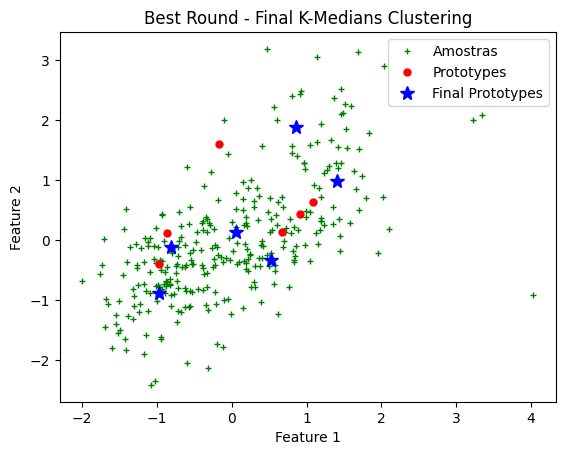

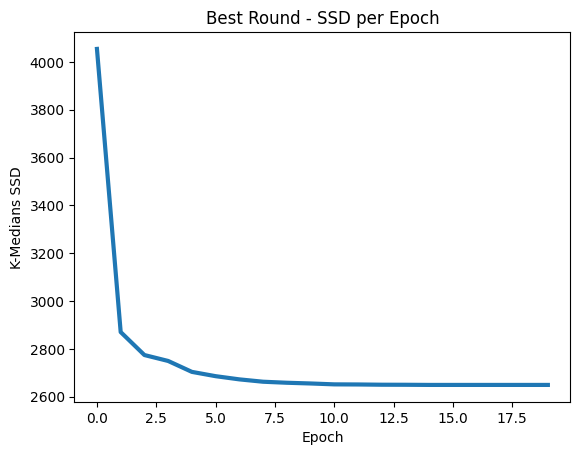

In [24]:
# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(k_best_prototypes[:, 0], k_best_prototypes[:, 1], '.r', markersize=10)
plt.plot(k_best_final_prototypes[:, 0], k_best_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Medians Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(k_best_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Medians SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()